### QPSK Implementation

The following quadrature phase shift keying (QPSK) system illustrates the core elements of a digital communication system, featuring simplified receiver and transmitter components that are fully synchronized. These core elements are divided into submodules, including bit-to-symbol mapping, upsampling and downsampling of the baseband signal, pulse shaping, and carrier frequency modulation. Each of these modules are summarized in Figure 1 and will be discussed separately below to showcase the functionality of the developed signal processing library and their performance objectives.

FULL SYSTEM DIAGRAM HERE !!!
<!-- <div style="text-align: center;">
    <img src="./images/QPSK/transmitter_receiver_diagram.png" alt="" width="750" />
    <p>QPSK System Transmitter and Receiver Architecture</p>
</div> -->

#### System Parameters

Before the transmitter can be further described system parameters must be configured to aid in the later design. QPSK modulation has already been selected and the remaining parameters will be set below including the constellation mapping, sample rate $f_s$, carrier frequencey $f_c$, and finally the input message.

In [6]:
import numpy as np
qpsk_constellation = [[complex( np.sqrt(1) +  np.sqrt(1)*1j), 3], 
                      [complex( np.sqrt(1) + -np.sqrt(1)*1j), 2], 
                      [complex(-np.sqrt(1) + -np.sqrt(1)*1j), 0], 
                      [complex(-np.sqrt(1) +  np.sqrt(1)*1j), 1]]
fs = 8
fc = .25 * fs
input_message_ascii = "this is a qpsk transceiver test!"

#### Bit to Symbol Mapping

Binary to symbol mapping in a practical system is done via lookup tables but for this example the simple 2-D constellation defined earlier will do. The input message represented by ascii characters will first need to be converted into a binary stream then blocked blocked into groups of 2 (QPSK includes two bits per symbol) for symbol mapping.

In [18]:
def string_to_ascii_binary(string, num_bits=7):
    return ['{:0{width}b}'.format(ord(char), width=num_bits) for char in string]

# mapping the ascii characters to binary
input_message_bins = ''.join(string_to_ascii_binary(input_message_ascii))

# grouping the binary into blocks of two bits
input_message_blocks = [input_message_bins[i:i+2] for i in range(0, len(input_message_bins), 2)]

# mapping each block to a symbol in the constellation
input_message_symbols = [int(bin2, 2) for bin2 in input_message_blocks]

The symbol representation stream can now be parallelized by being mapped onto the in-phase and quadrature channels using the previously defined constellation mapping. A header is also attached to the symbol stream in this section, which allows for the plotting of the message signal in later sections without revealing the symbol irregularities during startup.

In [47]:
bits_to_amplitude = {bit: amplitude for amplitude, bit in qpsk_constellation}

# adding header to input message symbols
ak = np.concatenate([np.ones(25), input_message_symbols])

# inphase channel symbol mapping
xk = np.real([bits_to_amplitude[bit] for bit in a_k])

# quadrature channel symbol mapping
yk = np.imag([bits_to_amplitude[bit] for bit in a_k])

A excerpt from the message signal is plotted below as well as some of the message configuration parameters printed.


Header Length: 25 symbols
Message Length: 137 symbols
Sample Rate: 8 samples per symbol
Carrier Frequency: 2.0 Hz



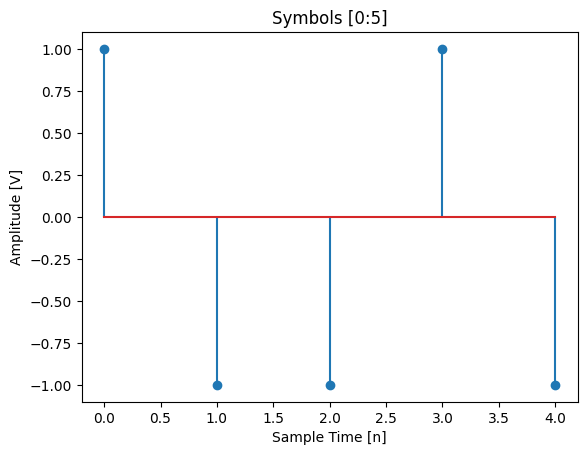

In [48]:
import matplotlib.pyplot as plt

# Plot original symbols
plt.figure()
plt.stem(yk[len(header):len(header)+5])
plt.title("Symbols [0:5]")
plt.xlabel("Sample Time [n]")
plt.ylabel("Amplitude [V]")

print(f"\nHeader Length: {len(header)} symbols")
print(f"Message Length: {len(xk)} symbols")
print(f"Sample Rate: {fs} samples per symbol")
print(f"Carrier Frequency: {fc} Hz\n")

plt.show()

#### Upsampling

The next step in the transmitter progression is upsampling the message symbols using the predefined sample rate $f_s$. Upsampling increases the sampling rate of the signal, allowing for finer resolution in the representation of the symbols. This is particularly important in digital communication systems to ensure that the signal can be accurately processed and transmitted. The upsampling process can be mathematically represented as follows:

$$
x\left(nT_s\right) \rightarrow x_{upsampled}\left(\frac{nT_s}{N}\right)
$$

where: 
- $ N $ is the upsample rate,
- $ T_s $ is the sample duration, 
- $ n $ is the sample index.

In [49]:
import sys
sys.path.insert(0, '../KUSignalLib/src')
from KUSignalLib import DSP

xk_upsampled = DSP.upsample(xk, fs, interpolate_flag=False)
yk_upsampled = DSP.upsample(yk, fs, interpolate_flag=False)

Text(0, 0.5, 'Amplutide [V]')

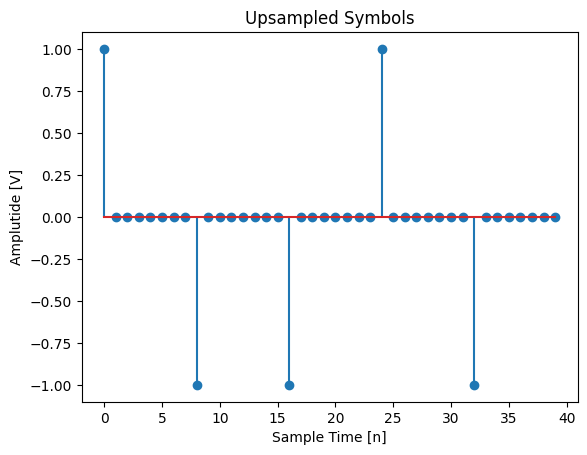

In [52]:
# Plot upsampled symbols
plt.figure()
plt.stem(yk_upsampled[len(header)*fs:(len(header)+5)*fs])
plt.title("Upsampled Symbols")
plt.xlabel("Sample Time [n]")
plt.ylabel("Amplutide [V]")

#### Pulse Shaping

Pulse shaping includes applying some form of windowing, sample and holding, or any other technique with the aim of altering a pulses waveform profile. The square root raised cosine (SRRC) pulse shape is commonly used in digital communication systems for pulse shaping to minimize intersymbol interference (ISI). The SRRC pulse is defined below by its impulse response and is characterized by its roll-off factor $\alpha$ as well as length.

$$
p\left(nT_s\right)=\frac{1}{\sqrt{N}}\cdot \frac{sin\left(\frac{\pi \left(1-\alpha \right)n}{N}\right)+\frac{4\alpha n}{N}cos\left(\frac{\pi \left(1+\alpha \right)n}{N}\right)}{\frac{\pi n}{N}\cdot \left[1-\left(\frac{4\alpha n}{N}\right)^2\right]}
$$

where: 
- $ N $ is the upsample rate,
- $ T_s $ is the sample duration, 
- $ n $ is the sample index,
- $ \alpha $ is the roll-off factor (0 ≤ $ \alpha $ ≤ 1).

In [70]:
from KUSignalLib import communications

length = 64
alpha = 0.10
pulse_shape = communications.srrc(alpha, fs, length)

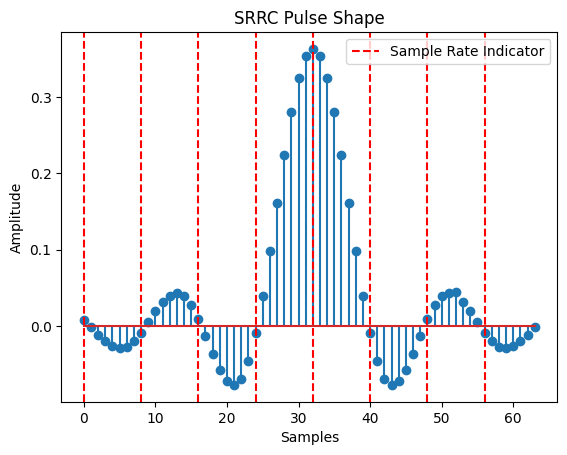

In [71]:
plt.figure()
plt.stem(pulse_shape)

# adding indicators at sample rate multiples
for i in range(0, length, fs):
    plt.axvline(x=i, color='red', linestyle='--', label='Sample Rate Indicator' if i == 0 else "")

plt.title("SRRC Pulse Shape")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

The configured SRRC pulse shape is applied to the upsampled message signal and shown below.

In [72]:
xk_pulse_shaped = DSP.convolve(xk_upsampled, pulse_shape, mode="same")
yk_pulse_shaped = DSP.convolve(yk_upsampled, pulse_shape, mode="same")


Filter Length: 64 samples
Message Length: 0.1 percent
Sample Rate: 8 samples per symbol



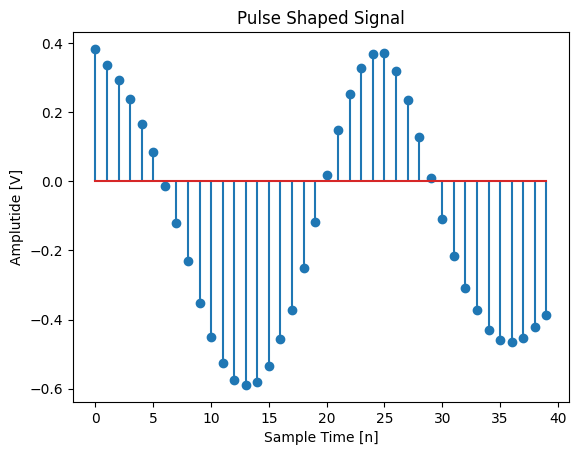

In [74]:
# Plot pulse shaped signal
plt.figure()
plt.stem(yk_pulse_shaped[len(header)*fs:(len(header)+5)*fs])
plt.title("Pulse Shaped Signal")
plt.xlabel("Sample Time [n]")
plt.ylabel("Amplutide [V]")

print(f"\nFilter Length: {length} samples")
print(f"Message Length: {alpha} percent")
print(f"Sample Rate: {fs} samples per symbol\n")

plt.show()


#### Digital Modulation

Modulation encompasses the process of mixing the baseband signal with a carrier, usually at some predefined radio frequency (RF). This is performed below via multiplication with a complex exponential representing two orthogonal sinusoids, one for the in-phase and quadrature channels. The resulting RF signal is defined in the following two forms.

$$
s_{RF}\left(nT\right) = Re\left\{x\left(nT\right) \cdot e^{j\theta}\right\} + Im\left\{y\left(nT\right) \cdot e^{j\theta}\right\}
$$

$$
s_{RF}\left(nT\right) = x\left(nT\right) \cdot \sqrt{2} \cos\left(\theta\right) + y\left(nT\right) \cdot \sqrt{2} \sin\left(\theta\right)
$$

In both cases, $\theta$ represents

$$
\theta = 2\pi \:\frac{f_c}{f_s}\:nT + \phi_c
$$

where:
- $f_c$ is the previously defined carrier frequency,
- $f_s$ is the system sample rate,
- $\phi_c$ represents the carrier phase offset,
- and the $ \sqrt{2}$ is used in both the modulator and demodulator to equalize the \(1/2\) terms that arise through the trigonometric double angle identities used.

In [80]:
s_RF = (
    np.sqrt(2) * np.real(DSP.modulate_by_exponential(xk_pulse_shaped, fc, fs)) +
    np.sqrt(2) * np.imag(DSP.modulate_by_exponential(yk_pulse_shaped, fc, fs))
)

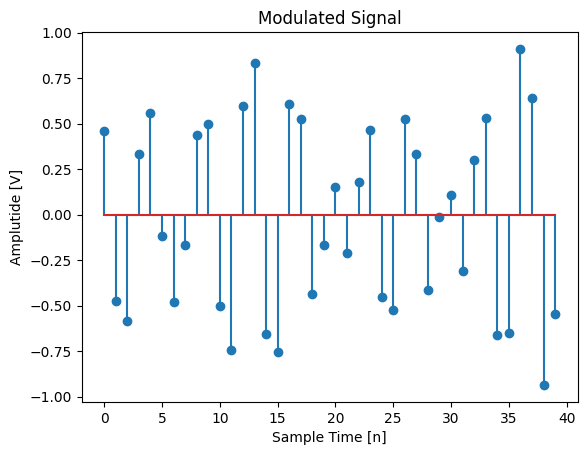

In [82]:
# Plot modulated RF signal
plt.figure()
plt.stem(s_RF[len(header)*fs:(len(header)+5)*fs])
plt.title("Modulated Signal")
plt.xlabel("Sample Time [n]")
plt.ylabel("Amplutide [V]")

plt.show()

In real systems, a Digital to Analog Converter (DAC) follows this step to facilitate open transmission, incorporating its own separate sampling and mixing parameters. At the receiving end, an accompanying Analog to Digital Converter (ADC) would ideally be matched to the transmitter in terms of sample rates and other mixing parameters. For simplicity, these components will be omitted in this example but will be reintroduced in future examples.

#### Digital Demodulation

Similarly to the tranmitters modulator module, the receiver uses the same architecture to demodulated the RF signal. This process is defined via the following two forms with the first represented as complex exponentials, and the next as sinusoidals. In both cases $\theta$ is defined the same as in the transmitter and the output realizes two seperate channels including the inphase and quadrature.

$$
s_{RF}\left(nT\right)\cdot \sqrt{2}cos\left(\theta \right)\:=\:s_{real}\left(nT\right)+s_{real}\left(nT\right)cos\left(2\theta \right)+s_{real}\left(nT\right)sin\left(2\theta \right)
$$
$$
s_{RF}\left(nT\right)\cdot \sqrt{2}sin\left(\theta \right)\:=\:s_{imag}\left(nT\right)-s_{imag}\left(nT\right)cos\left(2\theta \right)+s_{imag}\left(nT\right)sin\left(2\theta \right)
$$

$$
Re\left\{s_{RF}\left(nT\right)\cdot \:\:exp\left(j\theta \right)\right\}\:=\:s_{real}\left(nT\right)+...
$$
$$
Im\left\{s_{RF}\left(nT\right)\cdot \:\:exp\left(j\theta \right)\right\}\:=\:s_{imag}\left(nT\right)+...
$$

In both cases the following match filtering filters out the single and double frequency terms leave just the baseband inphase and quadrature chanels.

In [83]:
xr_nT = np.sqrt(2) * np.real(DSP.modulate_by_exponential(s_RF, fc, fs))
yr_nT = np.sqrt(2) * np.imag(DSP.modulate_by_exponential(s_RF, fc, fs))

# Plot demodulated signal
plt.figure()
plt.stem(yr_nT[len(header)*fs:(len(header)+5)*fs])
plt.title("Demodulated Signal")
plt.xlabel("Sample Time [n]")
plt.ylabel("Amplutide [V]")
plt.show()

#### Match Filtering

Match filtering is a pulse compresssion technique used to maximize the received signals signal to noise ratio (SNR). This includes filtering with the time reversed complex conjugate pulse shape applied during transmission which for this example corresponds to the previously defined SRRC filter. (NEED TO ADD CONV OPERATOR)

$$
s_{real}\left(nT\right)\star p^{\star }\left(-nT\right)\:=\:x_{MF}\left(nT\right)
$$

$$
s_{imag}\left(nT\right)\star p^{\star }\left(-nT\right)\:=\:y_{MF}\left(nT\right)
$$

In [ ]:
xr_nT_match_filtered = np.real(np.roll(DSP.convolve(xr_nT, pulse_shape, mode="same"), -1))
yr_nT_match_filtered = np.real(np.roll(DSP.convolve(yr_nT, pulse_shape, mode="same"), -1))

In [2]:
# plot match filtered signal
plt.figure()
plt.stem(yr_nT_match_filtered[len(header)*fs:(len(header)+5)*fs])
plt.title("Match Filtered Signal")
plt.xlabel("Sample Time [n]")
plt.ylabel("Amplutide [V]")
plt.show()

#### Downsampling

Becuase the developed system has complete synchronization, meaning no frequency, phase, or timing offsets were introduced, direct downsampling can be performed in to select the desired sample. This process is defined below

$$
x\left(nT_s\right)\:\rightarrow \:x_{downsampled}\left(nT_s\cdot N\right)
$$

where:
- $N $ is the down sample rate which matches the selected upsample rate used during transmission.

In [ ]:
xk = DSP.downsample(xr_nT_match_filtered, fs)
yk= DSP.downsample(yr_nT_match_filtered, fs)

# combinding inphase and quadrature signal components
rk = xk + 1j * yk

The downsampled received constellation points can now be plotted.

In [4]:
# plotting received constellations (ADD HOMEBREW HERE)
DSP.plot_complex_points(x_kTs[len(header)*sample_rate:], referencePoints=amplitudes)

#### NEAREST NEIGHBOR DECISION
